In [207]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import json
from sklearn.model_selection import GroupKFold,StratifiedKFold
import albumentations as A
import cv2
import pandas as pd
from PIL import Image
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
np.random.seed(42)

# Format Data

In [44]:
def permute(image):
    image = torch.Tensor(image)
    image = image.permute(2,0,1).numpy()
    return image

In [134]:
DATA_PATH = '../data/HAM_dataset/raw_data/HAM10000_images_part_1/'
OUT_PATH = '../data/HAM_dataset/processed_data/'
TABLE_PATH = '../data/split_tables/HAM/'
os.makedirs(TABLE_PATH,exist_ok=True)

df = pd.read_csv('../data/HAM_dataset/raw_data/HAM10000_metadata.csv')

enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
labelencoder = LabelEncoder()
mapping = labelencoder.fit(labels['dx'])

df

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

            dataset  
0      vidir_modern  
1      vidir_modern  
2      vidir_modern  
3      vidir_modern  
4      vidir_modern  
...             ...  
10010  vidir_modern  
10011  vidir_modern  
10012  vidir_modern  
10013  vidir_modern  
10014  vidir_modern  

[10015 rows x 8 columns]

In [138]:
temp

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   

        dataset  
0  vidir_modern  
1  vidir_modern

In [108]:
patient_list = df['lesion_id'].unique().tolist()

In [175]:
for patient in tqdm(patient_list):
    
    path = OUT_PATH+patient+'/'
    os.makedirs(path,exist_ok=True)
    
    temp = df[df['lesion_id']==patient]
    labels = mapping.transform(temp['dx'])
    
    for i in range(temp.shape[0]):
        
        image_name = temp['image_id'].tolist()[i]
        
        image = np.array(Image.open(DATA_PATH+f"{image_name}.jpg"))
        image = cv2.resize(image, (image.shape[1]//2,image.shape[0]//2), interpolation = cv2.INTER_AREA)
        
        
        target = np.zeros(7)
        target[labels[i]] = 1
        
        #save
        np.save(path+f'{image_name}.npy',image)
        np.save(path+f'{image_name}_label.npy',target)

100%|██████████| 7470/7470 [04:29<00:00, 27.67it/s]


# Prepare split tables

In [213]:
print(f'Total number of patients: {len(patient_list)}')

patient_list = np.array(patient_list)

patient_list = np.random.permutation(patient_list)
patient_list = patient_list.tolist()

patient_arr = []
records = []
labels_list = []
for patient in patient_list:
    records += [OUT_PATH[1:]+patient+'/'+i for i in os.listdir(OUT_PATH+patient) if i.find('_label')==-1]
    patient_arr += [patient]*len([OUT_PATH+patient+'/'+i for i in os.listdir(OUT_PATH+patient) if i.find('_label')==-1])

for record in records:
    labels_list += [np.argmax(np.load('.'+record[:-4]+'_label.npy'))]
    
records = np.array(records)
patient_arr = np.array(patient_arr)

print(f'Total number of images: {records.shape[0]}')

Total number of patients: 7470
Total number of images: 10015


In [214]:
#create test
kf = GroupKFold(n_splits=5)

for (train,test) in kf.split(records,records,patient_arr):
    
    records_test = records[test]
    
    
    #create test
    split = {
            'test': records_test.tolist(),
        }
    
    with open(f'{TABLE_PATH}test_split_table.json', 'w') as outfile:
            json.dump(split, outfile)
    break



print(f'Number of unique patients, test subset: {len(np.unique(patient_arr[test]))}')
print(f'Number of samples, test subset: {patient_arr[test].shape[0]}')

patient_arr = patient_arr[train]
records = records[train]

Number of unique patients, test subset: 1494
Number of samples, test subset: 2003


In [215]:
#create train and validation
n_patients = [200,400,800]

patients_unique = np.unique(patient_arr)

for i in n_patients:
    
    records_temp = records.copy()
    patient_arr_temp = patient_arr.copy()
    
    train_patients = patients_unique[:i]
    train_records = np.empty(0)
    for patient in train_patients.tolist():
        train_records = np.append(train_records,records[patient_arr==patient],axis=0)
        records_temp = records_temp[patient_arr_temp!=patient]
        patient_arr_temp = patient_arr_temp[patient_arr_temp!=patient]
    
    val_patients = patients_unique[-200:]
    val_records = np.empty(0)
    for patient in val_patients.tolist():
        val_records = np.append(val_records,records[patient_arr==patient],axis=0)
#         records_temp = records_temp[patient_arr_temp!=patient]
#         patient_arr_temp = patient_arr_temp[patient_arr_temp!=patient]
    
    
    split = {
            'train': train_records.tolist(),
            'val': val_records.tolist(),
            'pretrain': records_temp.tolist(),
        }
    with open(f'{TABLE_PATH}{i}_split_table.json', 'w') as outfile:
            json.dump(split, outfile)
            
    print(f'Number of unique patients, train subset: {train_patients.shape[0]}')
    print(f'Number of samples, train subset: {train_records.shape[0]}')
    print(f'Number of unique patients, pretain subset: {len(np.unique(patient_arr_temp))}')
    print(f'Number of samples, pretain subset: {records_temp.shape[0]}')
    print('#######################################################')



Number of unique patients, train subset: 200
Number of samples, train subset: 272
Number of unique patients, pretain subset: 5776
Number of samples, pretain subset: 7740
#######################################################
Number of unique patients, train subset: 400
Number of samples, train subset: 541
Number of unique patients, pretain subset: 5576
Number of samples, pretain subset: 7471
#######################################################
Number of unique patients, train subset: 800
Number of samples, train subset: 1068
Number of unique patients, pretain subset: 5176
Number of samples, pretain subset: 6944
#######################################################


In [182]:
#create UB

train_patients = patients_unique[patients_unique.shape[0]//5:]
train_records = np.empty(0)
for patient in train_patients.tolist():
    train_records = np.append(train_records,records[patient_arr==patient],axis=0)

val_patients = patients_unique[:patients_unique.shape[0]//5]
val_records = np.empty(0)
for patient in val_patients.tolist():
    val_records = np.append(val_records,records[patient_arr==patient],axis=0)

split = {
        'train': train_records.tolist(),
        'val': val_records.tolist(),
        }
with open(f'{TABLE_PATH}UB_split_table.json', 'w') as outfile:
            json.dump(split, outfile)

print(f'Number of unique patients, train subset: {train_patients.shape[0]}')
print(f'Number of samples, train subset: {train_records.shape[0]}')
print(f'Number of unique patients, validation subset: {val_patients.shape[0]}')
print(f'Number of samples, validation subset: {val_records.shape[0]}')
print('#######################################################')

Number of unique patients, train subset: 3825
Number of samples, train subset: 5146
Number of unique patients, validation subset: 956
Number of samples, validation subset: 1263
#######################################################


# Review augs

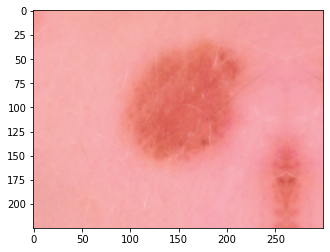

In [200]:
prob = 1
augs = A.Compose(
                [ 
                    A.HorizontalFlip(p=prob),
                    A.VerticalFlip(p=prob),
                    A.Rotate(limit=90, p=prob),
                    #A.ElasticTransform(alpha=0.1,p=prob),
                    #A.RandomSizedCrop(min_max_height=(120, 120), height=300, width=300, p=prob),
                    #A.RandomGamma(gamma_limit=(80, 120), p=prob)
                    #A.GlassBlur(sigma=10),
                    A.GridDistortion(distort_limit=0.3)
                ]
            )

augmented = augs(image=image)
augmented = augmented['image']


plt.imshow(augmented)

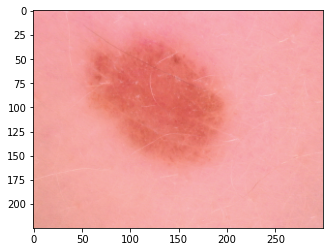

In [186]:
plt.imshow(image)

In [195]:
image.shape

(225, 300, 3)

In [ ]:
import numpy as np
import cv2

def rotate_image(image, angle):
    image = np.transpose(image.astype(np.float32), (1, 2, 0))
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    result = np.transpose(result.astype(np.float32), (2, 0, 1))
    return result

In [ ]:
y = rotate_image(image,90)
plt.imshow(y[2],'gray')